In [6]:
!pip install lightgbm

     |████████████████████████████████| 1.7 MB 3.0 MB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_csv('semi_clean_data.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.dropna()

print(data.shape)

(35742, 21)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC, SVC
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, cross_val_predict

from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc


In [33]:
def run_grid_search(model, param_grid, cat_vars, num_vars, month_transform, cv_num=5):
    features = cat_vars + num_vars

    X = data[features]
    y = data['cd'].values

    print(X.columns)

    new_data = pd.read_csv('test.csv')
    new_data2 = new_data[features]
    
    if (month_transform == 'number') or (month_transform == 'sine-cosine'):
        
        print('converting months to numbers ')
        print('='*20)

        month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                         'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
        X['month'] = X['month'].map(month_mapping)

        new_data2['month'] = new_data2['month'].map(month_mapping)
        
        if month_transform == 'sine-cosine':
            
            print('converting months to sine-cosine ')
            print('='*20)
        
            # Cyclical encoding for 'month'
            X['month_sin'] = np.sin((2 * np.pi * X['month'])/12)
            X['month_cos'] = np.cos((2 * np.pi * X['month'])/12)
            X.drop('month', axis=1, inplace=True)
            
            new_data2['month_sin'] = np.sin((2 * np.pi * new_data2['month'])/12)
            new_data2['month_cos'] = np.cos((2 * np.pi * new_data2['month'])/12)
            new_data2.drop('month', axis=1, inplace=True)

        cat_vars.remove('month')
    
    print(cat_vars)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),cat_vars),
                                     (StandardScaler(), num_vars),
                                     remainder='passthrough'
                                    )


    model_hp = make_pipeline(pipeline, model)

    stratified_kfold = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=42)
    grid = GridSearchCV(model_hp, param_grid, cv=stratified_kfold, scoring='roc_auc', verbose=3)
    # grid = GridSearchCV(model_hp, param_grid, cv=cv_num, scoring='roc_auc', verbose=3)
    grid.fit(X_train, y_train)
    print('Score using train set. = ', grid.score(X_train, y_train))

    # Predict probabilities
    y_pred_prob = grid.predict_proba(X_test)[:,1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    
    best_model = grid.best_estimator_
    new_predictions = best_model.predict(new_data2)
    answer = pd.DataFrame({'ID':list(new_data.id), 'cd':new_predictions})

    return grid, answer

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
['marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.905 total time= 4.4min
[CV 2/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.900 total time= 4.0min
[CV 3/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.894 total time= 3.8min
[CV 4/5] END xg

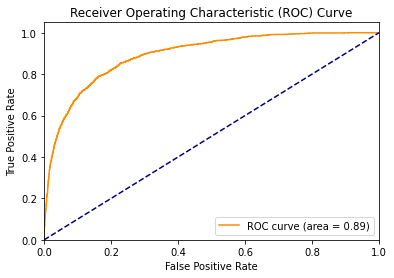

In [11]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [8],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': np.logspace(-2, 2, 4), #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_cat, ans_cat = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
#                       ,cv_num=2
                      ,month_transform = 'categorical'
                      )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
converting months to numbers 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.914 total time= 3.5min
[CV 2/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.913 total time= 3.9min
[CV 3/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.905 total time= 4

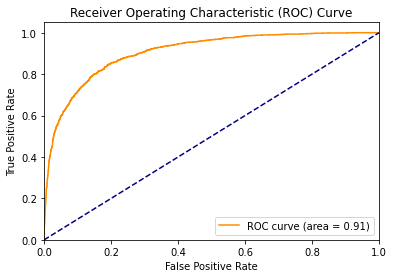

In [12]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [8],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': np.logspace(-2, 2, 4), #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_num, ans_num = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
#                       ,cv_num=2
                      ,month_transform = 'number'
                      )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
converting months to numbers 
converting months to sine-cosine 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.910 total time= 4.1min
[CV 2/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.906 total time= 4.2min
[CV 3/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=8, xgbclassifier__n_estimators=10000, xgbclassifier__subsamp

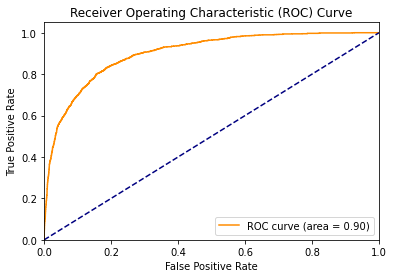

In [15]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [8],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': np.logspace(-2, 2, 4), #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
#                       ,cv_num=2
                      ,month_transform = 'sine-cosine'
                      )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')
converting months to numbers 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.921 total time= 5.4min
[CV 2/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.919 total time= 5.3min
[CV 3/5] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.914 total time

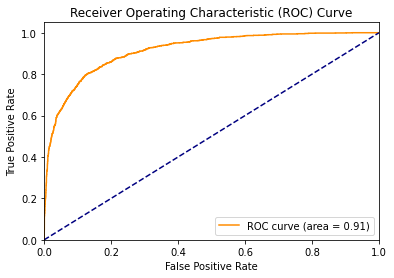

In [18]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [10],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': [10], #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_num1, ans_num1 = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
#                       ,cv_num=2
                      ,month_transform = 'number'
                      )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'age', 'balance', 'day', 'duration', 'pdays',
       'previous'],
      dtype='object')
converting months to numbers 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.829 total time= 5.9min
[CV 2/3] END xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.823 total time= 7.7min
[CV 3/3] END xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.820 total time=18.5min
Score using train set. =  0.9996283337303712


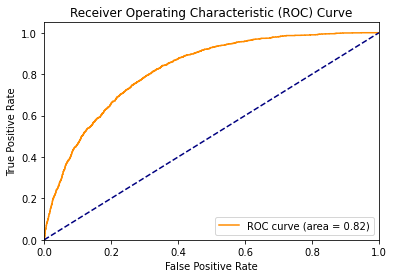

In [20]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [12]
#     ,
#     'xgbclassifier__colsample_bytree': [0.8],
#     'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': [10], #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_num1, ans_num1 = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['age', 'balance', 'day', 'duration', 'pdays', 'previous']
                      ,cv_num=3
                      ,month_transform = 'number'
                      )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'balance', 'day', 'duration', 'pdays',
       'campaign', 'previous'],
      dtype='object')
converting months to numbers 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.912 total time= 5.5min
[CV 2/3] END xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.904 total time= 6.1min
[CV 3/3] END xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.899 total time=25.1min
Score using train set. =  0.9999467527611378


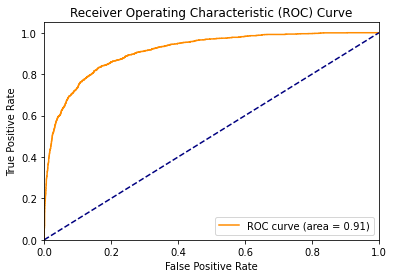

In [21]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [12]
#     ,
#     'xgbclassifier__colsample_bytree': [0.8],
#     'xgbclassifier__subsample': [0.8]
#     ,
#     'xgbclassifier__alpha': [10], #[0.1, 0.5, 1], # L1
    # 'classifier__lambda': [0, 0.1, 0.5, 1], # L2
#     'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_num1, ans_num1 = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['balance', 'day', 'duration', 'pdays', 'campaign', 'previous']
                      ,cv_num=3
                      ,month_transform = 'number'
                      )

In [25]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [12]
#     ,
#     'xgbclassifier__colsample_bytree': [0.8],
#     'xgbclassifier__subsample': [0.8]
    ,
    'xgbclassifier__alpha': [1, 10], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [1, 10], # L2
    'xgbclassifier__gamma': [0.5, 1]  # Added gamma to the grid
}
grid_num1, ans_num1 = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['marital', 'education', 'housing',
                                  'loan', 'contact', 'month', 'poutcome', 'generation'],
                      num_vars = ['balance', 'day', 'duration', 'pdays', 'campaign', 'previous']
                      ,month_transform = 'number'
                        ,cv_num=3
                      )

Index(['marital', 'education', 'housing', 'loan', 'contact', 'month',
       'poutcome', 'generation', 'balance', 'day', 'duration', 'pdays',
       'campaign', 'previous'],
      dtype='object')
converting months to numbers 
['marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'generation']
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END xgbclassifier__alpha=1, xgbclassifier__gamma=0.5, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.915 total time= 5.6min
[CV 2/3] END xgbclassifier__alpha=1, xgbclassifier__gamma=0.5, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, score=0.901 total time= 5.7min
[CV 3/3] END xgbclassifier__alpha=1, xgbclassifier__gamma=0.5, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=12, xgbclassifier__n_estimators=10000;, scor

KeyboardInterrupt: 

Index(['loan', 'contact', 'month', 'state', 'housing', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month', 'state', 'housing']
Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.900 total time=  38.3s
[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.895 total time=  34.2s
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=5000, xgbclassifier__subsample=0.8;, score=0.917 total time= 3.2min
[CV 2

[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.895 total time=  14.1s
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=5000, xgbclassifier__subsample=0.8;, score=0.919 total time=11.4min
[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=5000, xgbclassifier__subsample=0.8;, score=0.910 total time=11.4min
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbcl

[CV 2/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=50, xgbclassifier__n_estimators=5000, xgbclassifier__subsample=0.8;, score=0.873 total time= 5.5min
[CV 1/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=50, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.891 total time=10.9min
[CV 2/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=50, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.882 total time=13.0min
[CV 1/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=1000, xgb

[CV 1/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.891 total time= 9.9min
[CV 2/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.882 total time= 9.2min
[CV 1/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=50, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.846 total time=  34.1s
[CV 2/2] END xgbclassifier__alpha=10.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=50, xgbclassifier__n_estimators=1000, xgbclassifie

[CV 2/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.717 total time=  30.0s
[CV 1/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.698 total time=   3.9s
[CV 2/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.685 total time=   3.4s
[CV 1/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.5, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=20, xgbclassifier__n_estimators=50

[CV 1/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.698 total time=   3.7s
[CV 2/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=1000, xgbclassifier__subsample=0.8;, score=0.685 total time=   3.3s
[CV 1/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=5000, xgbclassifier__subsample=0.8;, score=0.700 total time=  19.9s
[CV 2/2] END xgbclassifier__alpha=1000.0, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=5000, xg

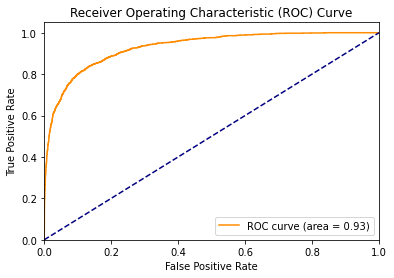

In [31]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [1000, 5000, 10000],
    'xgbclassifier__learning_rate': [0.001, 0.01, 0.1],
    'xgbclassifier__max_depth': [20,50,100],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8]
    ,
    'xgbclassifier__alpha': np.logspace(-1, 3, 3), #[0.1, 0.5, 1], # L1
#     'classifier__lambda': [0, 0.1, 0.5, 1], # L2
    'xgbclassifier__gamma': [0.1, 0.5, 1]  # Added gamma to the grid
}
grid_cat, ans_cat = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month', 'state', 'housing'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=2
                      ,month_transform = 'categorical'
                      )

In [32]:
print(grid_cat.best_params_)

{'xgbclassifier__alpha': 0.1, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 1, 'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__max_depth': 100, 'xgbclassifier__n_estimators': 10000, 'xgbclassifier__subsample': 0.8}


Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
converting months to numbers 
converting months to sine-cosine 
['loan', 'contact']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.894 total time= 6.5min
[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.886 total time= 7.0min
Score using train set. =  0.9304674890623839


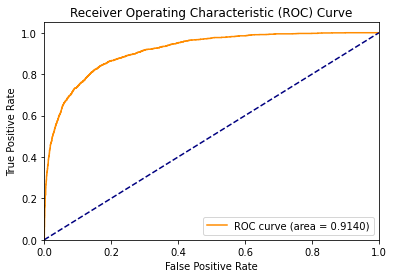

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                                          'campaign'])])),
                                       ('xgbclassi

In [34]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [100],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [10], # L2
    'xgbclassifier__gamma': [10]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=2
                      ,month_transform = 'sine-cosine'
                      )
print(grid_sc)

Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.894 total time= 7.4min
[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.883 total time= 7.5min
Score using train set. =  0.9300519009393086


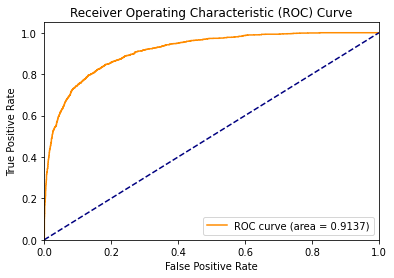

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                          

In [35]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [100],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [10], # L2
    'xgbclassifier__gamma': [10]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=2
                      ,month_transform = 'categorical'
                      )
print(grid_sc)

Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;, score=0.909 total time= 5.2min
[CV 2/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;, score=0.905 total time= 3.6min
[CV 3/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;

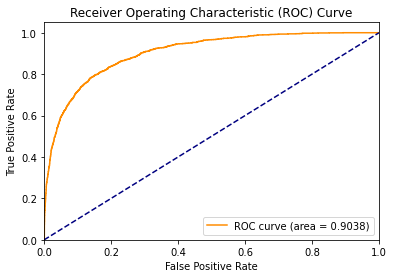

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                          

In [36]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [100],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.6],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [10], # L2
    'xgbclassifier__gamma': [10]  # Added gamma to the grid
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=5
                      ,month_transform = 'categorical'
                      )
print(grid_sc)

Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.0001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;, score=0.874 total time= 7.0min
[CV 2/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.0001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;, score=0.864 total time= 7.6min
[CV 3/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.0001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0

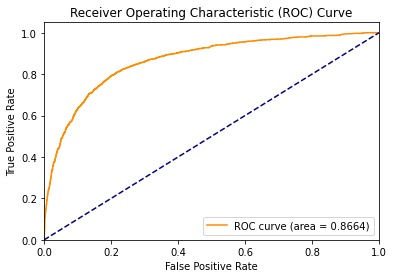

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                          

In [37]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.0001],
    'xgbclassifier__max_depth': [100],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.6],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [10], # L2
    'xgbclassifier__gamma': [10]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=5
                      ,month_transform = 'categorical'
                      )
print(grid_sc)

Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=500, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;, score=0.909 total time= 3.6min
[CV 2/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=500, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;, score=0.905 total time= 3.7min
[CV 3/5] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=10, xgbclassifier__lambda=10, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=500, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.6;

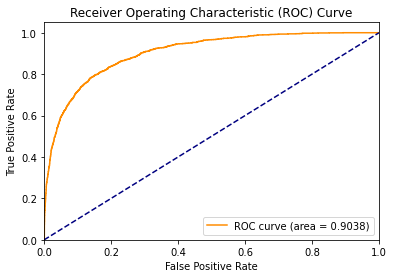

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                          

In [39]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [500],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.6],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [10], # L2
    'xgbclassifier__gamma': [10]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=5
                      ,month_transform = 'categorical'
                      )
print(grid_sc)

Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=500, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.924 total time= 3.6min
[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=500, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.918 total time= 3.4min
Score using train set. =  0.9970326359201533


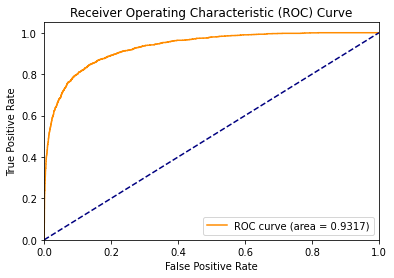

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                          

In [41]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [500],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [1], # L2
    'xgbclassifier__gamma': [1]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=2
                      ,month_transform = 'categorical'
                      )
print(grid_sc)

Index(['loan', 'contact', 'month', 'balance', 'campaign'], dtype='object')
['loan', 'contact', 'month']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.924 total time= 3.8min
[CV 2/2] END xgbclassifier__alpha=0.1, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__lambda=1, xgbclassifier__learning_rate=0.001, xgbclassifier__max_depth=100, xgbclassifier__n_estimators=10000, xgbclassifier__subsample=0.8;, score=0.918 total time= 3.7min
Score using train set. =  0.9970276935675776


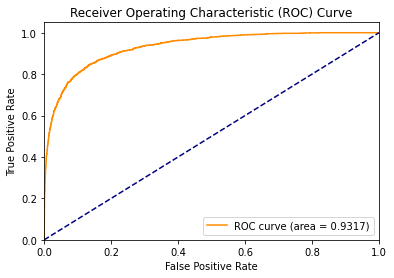

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['loan',
                                                                          'contact',
                                                                          'month']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['balance',
                                                          

In [42]:
param_grid_xgb = {
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__learning_rate': [0.001],
    'xgbclassifier__max_depth': [100],
    'xgbclassifier__colsample_bytree': [0.8],
    'xgbclassifier__subsample': [0.8],
    'xgbclassifier__alpha': [0.1], #[0.1, 0.5, 1], # L1
    'xgbclassifier__lambda': [1], # L2
    'xgbclassifier__gamma': [1]  # Added gamma to the grid
}
grid_sc, ans_sc = run_grid_search(XGBClassifier(), param_grid = param_grid_xgb,
                      cat_vars = ['loan','contact', 'month'],
                      num_vars = ['balance', 'campaign']
                      ,cv_num=2
                      ,month_transform = 'categorical'
                      )
print(grid_sc)

In [43]:
data= pd.read_csv('semi_clean_data.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.dropna()

new_data = pd.read_csv('test.csv')


cat_vars = ['loan','contact', 'month']
num_vars = ['balance', 'campaign']
features = cat_vars + num_vars

# Create and fit the pipeline to the training data.
pipeline = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_vars),
    (StandardScaler(), num_vars),
    remainder='passthrough'
)


X_train = data[features]
y = data['cd'].values


X_test = new_data[features]



X_train_preprocessed = pipeline.fit_transform(X_train).toarray()
X_test_preprocessed = pipeline.transform(X_test).toarray()


xgb_model = XGBClassifier(n_estimators=10000, 
                          learning_rate=0.001,
                          max_depth=100,
                          colsample_bytree=0.8,
                          subsample=0.8,
                          reg_alpha=0.1, # L1 regularization
                          reg_lambda=1, # L2 regularization
                          gamma=1)

xgb_model.fit(X_train_preprocessed, y)


xgb_predictions = xgb_model.predict(X_test_preprocessed)

answer_final_df = pd.DataFrame({'ID':list(new_data.id), 'cd':xgb_predictions})
answer_final_df.to_csv('answer_xgb_KB.csv', index=False)